<a href="https://colab.research.google.com/github/Mehdi007bond/Predictive_maintenance_Project/blob/main/Predictive_maintenance_Project_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I started by generating the dataset so i can work


In [2]:
import pandas as pd
import numpy as np
import datetime

# --- 1. Configuration Générale ---
N_LINES = 4  # Nombre de lignes de production à simuler
DAYS_PER_MACHINE = 60
SAMPLES_PER_HOUR = 4
N_SAMPLES_PER_DAY = 24 * SAMPLES_PER_HOUR
TOTAL_SAMPLES_PER_MACHINE = DAYS_PER_MACHINE * N_SAMPLES_PER_DAY

# --- Paramètres de simulation (MIS À JOUR) ---
# Notre "état de panne" (cible=1) commence 58h avant la panne
# pour atteindre notre objectif de 4.02%
FAILURE_STATE_HOURS = 58
FAILURE_STATE_SAMPLES = FAILURE_STATE_HOURS * SAMPLES_PER_HOUR

# --- 2. Profils des Machines ---
def get_machine_parameters(machine_type):
    """Définit les profils de capteurs et de défaillance pour chaque type de machine."""

    if machine_type == 'Fraiseuse':
        return {
            'BASE_TEMP': 45.0, 'TEMP_NOISE': 2.0, 'TEMP_DEGRADE_RATE': 0.1,
            'BASE_VIB': 1.2, 'VIB_NOISE': 0.3, 'VIB_DEGRADE_RATE': 0.1,
            'BASE_CUR': 10.0, 'CUR_NOISE': 0.5, 'CUR_DEGRADE_RATE': 0.08,
            'BASE_TORQUE': 80.0, 'TORQUE_NOISE': 3.0, 'TORQUE_DEGRADE_RATE': 0.15
        }
    elif machine_type == 'Convoyeur':
        return {
            'BASE_TEMP': 30.0, 'TEMP_NOISE': 1.0, 'TEMP_DEGRADE_RATE': 0.05,
            'BASE_VIB': 0.4, 'VIB_NOISE': 0.1, 'VIB_DEGRADE_RATE': 0.03,
            'BASE_CUR': 3.0, 'CUR_NOISE': 0.1, 'CUR_DEGRADE_RATE': 0.15,
            'BASE_TORQUE': 20.0, 'TORQUE_NOISE': 1.0, 'TORQUE_DEGRADE_RATE': 0.05
        }
    elif machine_type == 'Machine_de_finition':
        return {
            'BASE_TEMP': 35.0, 'TEMP_NOISE': 0.5, 'TEMP_DEGRADE_RATE': 0.03,
            'BASE_VIB': 0.2, 'VIB_NOISE': 0.05, 'VIB_DEGRADE_RATE': 0.08,
            'BASE_CUR': 2.0, 'CUR_NOISE': 0.1, 'CUR_DEGRADE_RATE': -0.05,
            'BASE_TORQUE': 10.0, 'TORQUE_NOISE': 0.5, 'TORQUE_DEGRADE_RATE': -0.02
        }
    else:
        raise ValueError("Type de machine inconnu")

# --- 3. Fonction de Génération (Simplifiée) ---
def generate_machine_data(machine_id, machine_type, production_line, start_date):

    print(f"Génération des données pour Machine ID: {machine_id} (Type: {machine_type})...")

    params = get_machine_parameters(machine_type)
    total_samples = TOTAL_SAMPLES_PER_MACHINE

    time_offset_seconds = np.random.randint(0, 30)
    base_timestamps = [start_date + datetime.timedelta(hours=i/SAMPLES_PER_HOUR) for i in range(total_samples)]
    timestamps = [ts + datetime.timedelta(seconds=time_offset_seconds) for ts in base_timestamps]

    # Initialisation des capteurs
    temp = np.random.normal(loc=params['BASE_TEMP'], scale=params['TEMP_NOISE'], size=total_samples)
    vib = np.random.normal(loc=params['BASE_VIB'], scale=params['VIB_NOISE'], size=total_samples)
    curr = np.random.normal(loc=params['BASE_CUR'], scale=params['CUR_NOISE'], size=total_samples)
    torque = np.random.normal(loc=params['BASE_TORQUE'], scale=params['TORQUE_NOISE'], size=total_samples)

    # Feature "Odomètre": total_working_hours
    total_working_hours = (np.arange(total_samples) / SAMPLES_PER_HOUR).round(2)

    # --- CIBLE ML (Simplifiée) ---
    # 0 = 'Healthy', 1 = 'Failing'
    failure = np.zeros(total_samples, dtype=int)

    # Définir le point de panne exact
    failure_sample = total_samples - np.random.randint(N_SAMPLES_PER_DAY * 3, N_SAMPLES_PER_DAY * 15)

    # L'état de panne commence 58h avant
    failing_state_start_sample = failure_sample - FAILURE_STATE_SAMPLES

    # Mettre la cible à 1 pendant l'état de panne
    failure[failing_state_start_sample:failure_sample] = 1

    # Appliquer la dégradation des capteurs PENDANT l'état de panne
    for i in range(failing_state_start_sample, failure_sample):
        progress = (i - failing_state_start_sample) / (failure_sample - failing_state_start_sample)
        temp[i] += params['TEMP_DEGRADE_RATE'] * progress * 20
        vib[i] += params['VIB_DEGRADE_RATE'] * progress * 15
        curr[i] += params['CUR_DEGRADE_RATE'] * progress * 10
        torque[i] += params['TORQUE_DEGRADE_RATE'] * progress * 10

    # --- Assemblage du DataFrame (Simplifié) ---
    df = pd.DataFrame({
        'timestamp': timestamps,
        'production_line': production_line,
        'machine_id': machine_id,
        'machine_type': machine_type,
        'temperature': temp.round(2),
        'vibration': vib.round(4),
        'current': curr.round(3),
        'torque': torque.round(2),
        'total_working_hours': total_working_hours,
        'failure': failure                  # NOTRE CIBLE ML (0 ou 1)
    })

    return df

# --- 4. Boucle Principale de Génération ---
print("Démarrage de la génération du dataset (Cible = failure)...")
all_data_frames = []
start_date = datetime.datetime(2024, 1, 1)
machine_id_counter = 1
machine_types = ['Fraiseuse', 'Convoyeur', 'Machine_de_finition']

for i in range(N_LINES):
    line_name = f"Line_{i+1}"
    print(f"\n--- Génération des données pour {line_name} ---")
    for machine_type in machine_types:
        machine_df = generate_machine_data(
            machine_id=machine_id_counter,
            machine_type=machine_type,
            production_line=line_name,
            start_date=start_date
        )
        all_data_frames.append(machine_df)
        machine_id_counter += 1

# --- 5. Finalisation : Mélange et Sauvegarde ---
print("\nFinalisation du dataset...")
full_dataset = pd.concat(all_data_frames)

print("Tri du dataset par timestamp pour simuler la collecte 'temps réel'...")
full_dataset.sort_values(by='timestamp', inplace=True)
full_dataset.reset_index(drop=True, inplace=True)

print("\nDataset de CLASSIFICATION (4%) généré et mélangé !")
print(f"Nombre total d'échantillons: {len(full_dataset)}")

# Sauvegarde
output_filename = "production_line_STATE_BASED_4_PERCENT_data.csv"
full_dataset.to_csv(output_filename, index=False)
print(f"Dataset sauvegardé sous '{output_filename}'")

# Affichage d'un échantillon
print("\n--- Aperçu du Dataset ---")
print(full_dataset.head(10))

print("\n--- Distribution de la Cible (failure) ---")
print(full_dataset['failure'].value_counts())
target_rate = full_dataset['failure'].mean() * 100
print(f"Pourcentage de 'failure' (1): {target_rate:.2f}%")

Démarrage de la génération du dataset (Cible = failure)...

--- Génération des données pour Line_1 ---
Génération des données pour Machine ID: 1 (Type: Fraiseuse)...
Génération des données pour Machine ID: 2 (Type: Convoyeur)...
Génération des données pour Machine ID: 3 (Type: Machine_de_finition)...

--- Génération des données pour Line_2 ---
Génération des données pour Machine ID: 4 (Type: Fraiseuse)...
Génération des données pour Machine ID: 5 (Type: Convoyeur)...
Génération des données pour Machine ID: 6 (Type: Machine_de_finition)...

--- Génération des données pour Line_3 ---
Génération des données pour Machine ID: 7 (Type: Fraiseuse)...
Génération des données pour Machine ID: 8 (Type: Convoyeur)...
Génération des données pour Machine ID: 9 (Type: Machine_de_finition)...

--- Génération des données pour Line_4 ---
Génération des données pour Machine ID: 10 (Type: Fraiseuse)...
Génération des données pour Machine ID: 11 (Type: Convoyeur)...
Génération des données pour Machine ID: 

# Starting by exploratory data analysis

In [3]:
df = full_dataset
display(df.head(10))
display(df.shape)
df.isna().sum()
display(df.describe())
#


,timestamp,production_line,machine_id,machine_type,temperature,vibration,current,torque,total_working_hours,failure
0,2024-01-01 00:00:02,Line_4,12,Machine_de_finition,34.21,0.1998,2.016,10.75,0.0,0
1,2024-01-01 00:00:03,Line_4,10,Fraiseuse,47.26,1.4240,10.015,79.37,0.0,0
2,2024-01-01 00:00:06,Line_2,4,Fraiseuse,44.62,1.2882,10.001,84.08,0.0,0
3,2024-01-01 00:00:06,Line_2,5,Convoyeur,27.86,0.4712,2.903,18.29,0.0,0
4,2024-01-01 00:00:09,Line_2,6,Machine_de_finition,35.78,0.2230,2.147,10.26,0.0,0
5,2024-01-01 00:00:13,Line_3,7,Fraiseuse,43.04,1.6478,10.738,81.82,0.0,0
6,2024-01-01 00:00:14,Line_1,3,Machine_de_finition,34.68,0.1596,1.911,9.68,0.0,0
7,2024-01-01 00:00:15,Line_1,1,Fraiseuse,44.14,1.2481,10.494,82.22,0.0,0
8,2024-01-01 00:00:20,Line_1,2,Convoyeur,30.50,0.4533,2.993,19.82,0.0,0
9,2024-01-01 00:00:21,Line_3,9,Machine_de_finition,35.24,0.2348,1.942,10.28,0.0,0


(69120, 10)

,timestamp,machine_id,temperature,vibration,current,torque,total_working_hours,failure
count,69120,69120.000000,69120.000000,69120.000000,69120.000000,69120.000000,69120.000000,69120.000000
mean,2024-01-30 23:52:43.583333376,6.500000,36.683500,0.620425,5.011828,36.685280,719.875000,0.040278
min,2024-01-01 00:00:02,1.000000,26.030000,-0.041700,1.301000,8.190000,0.000000,0.000000
25%,2024-01-15 23:56:23.750000128,3.750000,30.690000,0.231100,2.066000,10.330000,359.937500,0.000000
50%,2024-01-30 23:52:45.500000,6.500000,35.010000,0.408800,3.004000,20.020000,719.875000,0.000000
75%,2024-02-14 23:49:07.249999872,9.250000,43.670000,1.019825,9.671000,78.010000,1079.812500,0.000000
max,2024-02-29 23:45:29,12.000000,52.630000,3.346300,12.301000,91.700000,1439.750000,1.000000
std,NaN,3.452078,6.382974,0.491262,3.577718,30.984318,415.695195,0.196611


In [4]:
df.info()
df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69120 entries, 0 to 69119
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   timestamp            69120 non-null  datetime64[ns]
 1   production_line      69120 non-null  object        
 2   machine_id           69120 non-null  int64         
 3   machine_type         69120 non-null  object        
 4   temperature          69120 non-null  float64       
 5   vibration            69120 non-null  float64       
 6   current              69120 non-null  float64       
 7   torque               69120 non-null  float64       
 8   total_working_hours  69120 non-null  float64       
 9   failure              69120 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(2), object(2)
memory usage: 5.3+ MB


Index(['timestamp', 'production_line', 'machine_id', 'machine_type',
       'temperature', 'vibration', 'current', 'torque', 'total_working_hours',
       'failure'],
      dtype='object')

failure
0    66336
1     2784
Name: count, dtype: int64


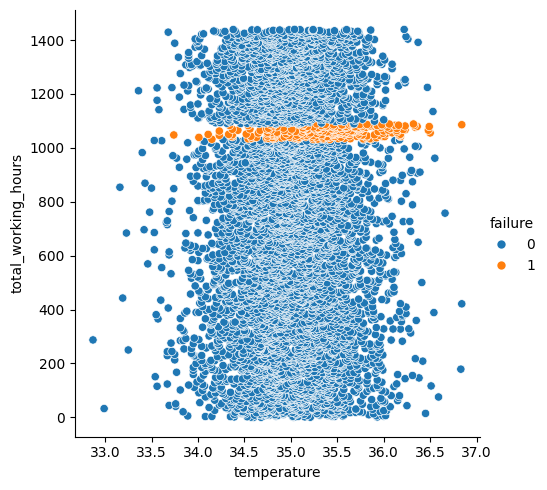

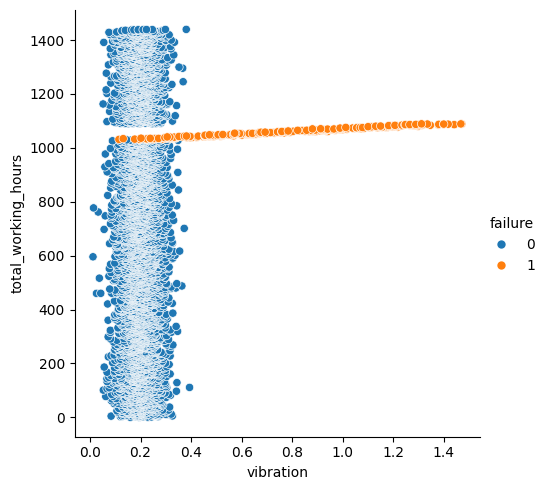

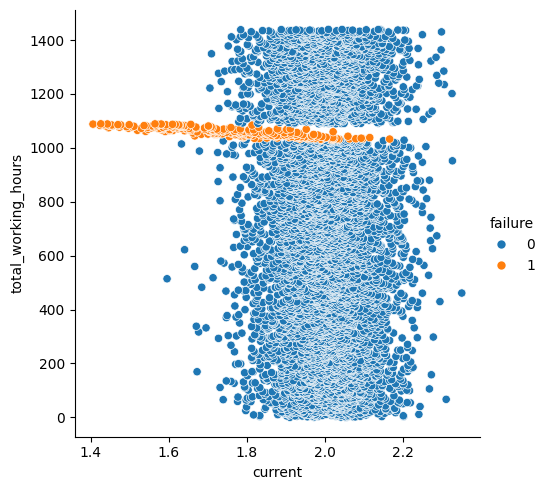

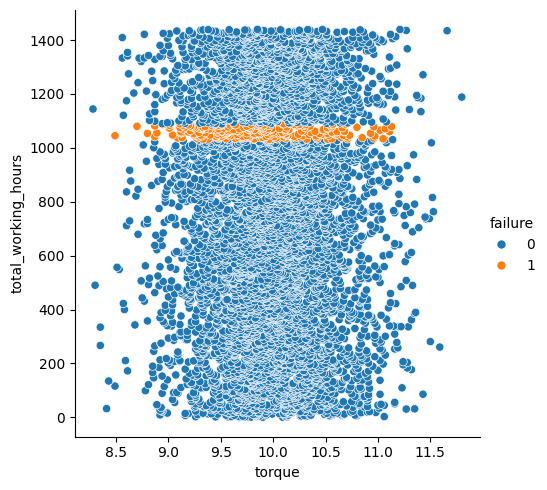

,timestamp,production_line,machine_id,machine_type,temperature,vibration,current,torque,total_working_hours,failure
6,2024-01-01 00:00:14,Line_1,3,Machine_de_finition,34.68,0.1596,1.911,9.68,0.00,0
18,2024-01-01 00:15:14,Line_1,3,Machine_de_finition,34.60,0.2298,2.054,9.90,0.25,0
30,2024-01-01 00:30:14,Line_1,3,Machine_de_finition,35.21,0.1965,2.057,10.09,0.50,0
42,2024-01-01 00:45:14,Line_1,3,Machine_de_finition,34.57,0.1956,1.973,9.76,0.75,0
54,2024-01-01 01:00:14,Line_1,3,Machine_de_finition,35.03,0.2288,2.042,9.79,1.00,0
...,...,...,...,...,...,...,...,...,...,...
69066,2024-02-29 22:45:14,Line_1,3,Machine_de_finition,35.60,0.2100,2.142,9.38,1438.75,0
69078,2024-02-29 23:00:14,Line_1,3,Machine_de_finition,35.24,0.2467,1.889,10.33,1439.00,0
69090,2024-02-29 23:15:14,Line_1,3,Machine_de_finition,34.38,0.2234,2.138,10.47,1439.25,0
69102,2024-02-29 23:30:14,Line_1,3,Machine_de_finition,36.22,0.2983,2.045,11.21,1439.50,0


,timestamp,production_line,machine_id,machine_type,temperature,vibration,current,torque,total_working_hours,failure
0,2024-01-01 00:00:02,Line_4,12,Machine_de_finition,34.21,0.1998,2.016,10.75,0.0,0
1,2024-01-01 00:00:03,Line_4,10,Fraiseuse,47.26,1.4240,10.015,79.37,0.0,0
2,2024-01-01 00:00:06,Line_2,4,Fraiseuse,44.62,1.2882,10.001,84.08,0.0,0
3,2024-01-01 00:00:06,Line_2,5,Convoyeur,27.86,0.4712,2.903,18.29,0.0,0
4,2024-01-01 00:00:09,Line_2,6,Machine_de_finition,35.78,0.2230,2.147,10.26,0.0,0


In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

for col in ['failure'] :
  col_counts = df[col].value_counts()
  print(col_counts)

# building a plot where we can see a evolution of each line (1 2 3)
#making a classification of each variable so we ca ddisplay it
df_line1 = df[(df['production_line'] == 'Line_1') & (df['machine_type'] == 'Machine_de_finition')]
criteria=['temperature', 'vibration', 'current', 'torque']

for i in criteria:
  sns.relplot(x=i ,y='total_working_hours', hue='failure' , data=df_line1)
  plt.show()
display(df_line1)
df.head()

Exception ignored in: <function Client.__del__ at 0x7b6a69227c40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/google/genai/client.py", line 400, in __del__
    self.close()
  File "/usr/local/lib/python3.12/dist-packages/google/genai/client.py", line 386, in close
    self._api_client.close()
    ^^^^^^^^^^^^^^^^
AttributeError: 'Client' object has no attribute '_api_client'


array([[<Axes: title={'center': 'timestamp'}>,
        <Axes: title={'center': 'machine_id'}>,
        <Axes: title={'center': 'temperature'}>],
       [<Axes: title={'center': 'vibration'}>,
        <Axes: title={'center': 'current'}>,
        <Axes: title={'center': 'torque'}>],
       [<Axes: title={'center': 'total_working_hours'}>,
        <Axes: title={'center': 'failure'}>, <Axes: >]], dtype=object)

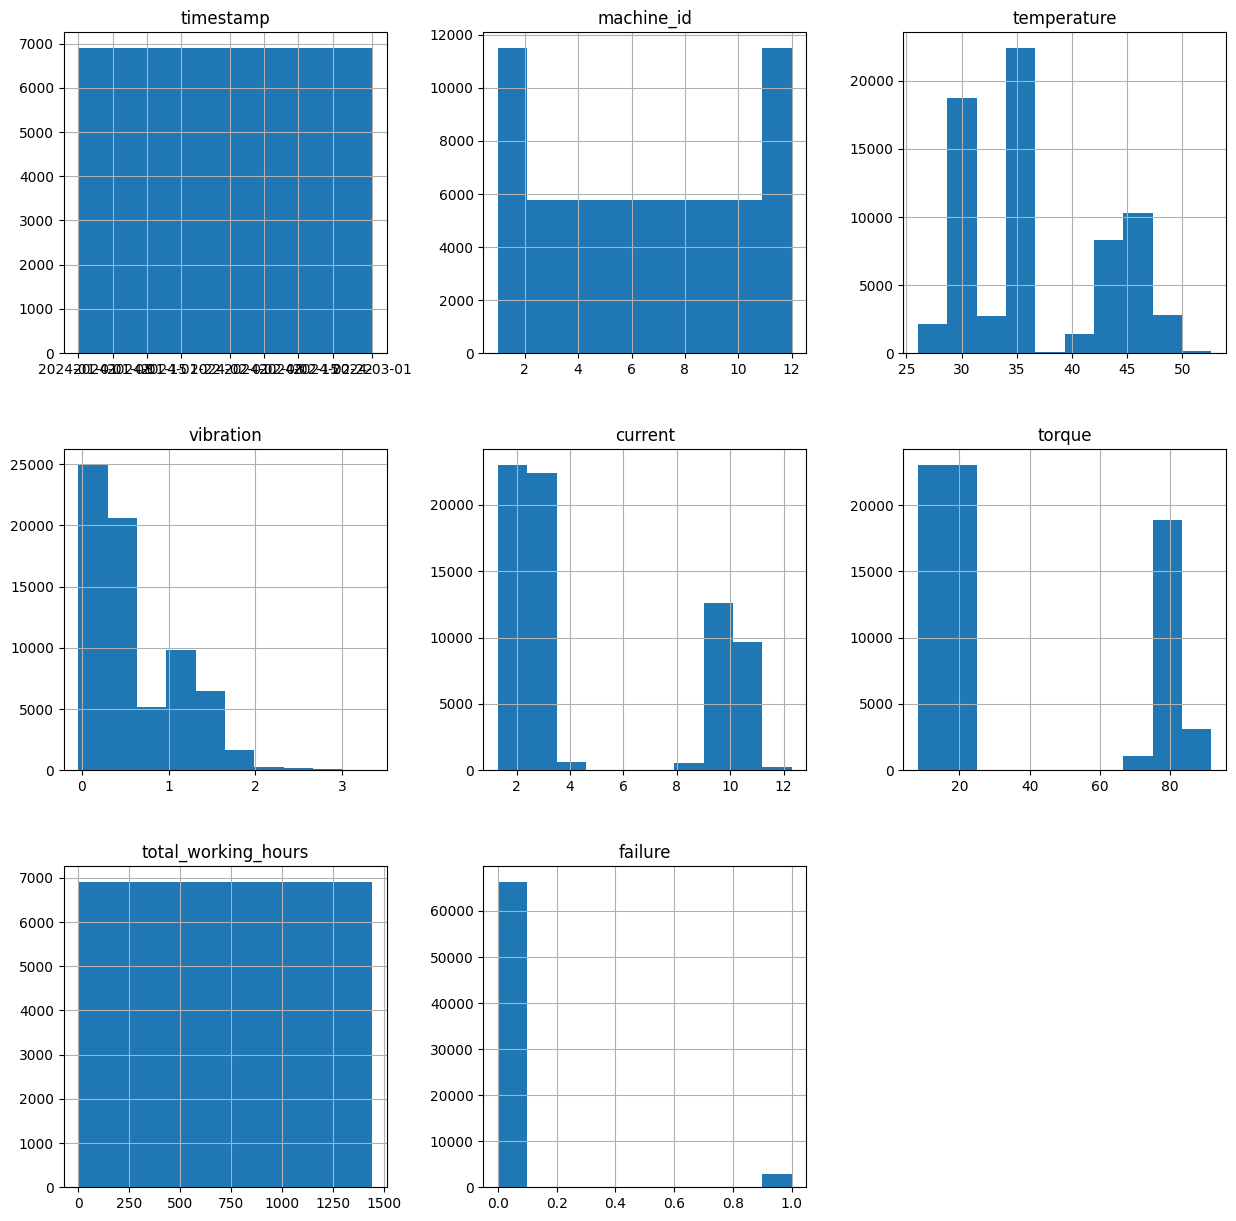

In [25]:
df.hist(figsize=(15,15))

In [36]:
df.columns
failure_cols = ['temperature', 'vibration', 'current', 'torque']
def classify_failure_type(row):
  for col in failure_cols :
    if row[col] == 1 :
      return col
  return "No failure"
df["Failure_Type"] = df.apply(classify_failure_type, axis=1)
df.tail(100)
df_line2 = df[(df['production_line'] == 'Line_2') & (df['failure'] == 1)]
df_line2

,timestamp,production_line,machine_id,machine_type,temperature,vibration,current,torque,total_working_hours,failure,Failure_Type
49827,2024-02-13 06:00:06,Line_2,5,Convoyeur,29.85,0.4052,2.958,19.86,1038.00,1,No failure
49838,2024-02-13 06:15:06,Line_2,5,Convoyeur,29.41,0.4769,2.952,21.32,1038.25,1,No failure
49850,2024-02-13 06:30:06,Line_2,5,Convoyeur,29.63,0.3056,3.059,20.16,1038.50,1,No failure
49863,2024-02-13 06:45:06,Line_2,5,Convoyeur,28.90,0.5524,2.987,19.70,1038.75,1,No failure
49875,2024-02-13 07:00:06,Line_2,5,Convoyeur,29.84,0.5546,2.943,21.00,1039.00,1,No failure
...,...,...,...,...,...,...,...,...,...,...,...
58120,2024-02-20 10:45:09,Line_2,6,Machine_de_finition,35.16,1.4047,1.572,9.99,1210.75,1,No failure
58132,2024-02-20 11:00:09,Line_2,6,Machine_de_finition,35.26,1.3030,1.602,9.58,1211.00,1,No failure
58144,2024-02-20 11:15:09,Line_2,6,Machine_de_finition,35.67,1.3031,1.641,10.11,1211.25,1,No failure
58156,2024-02-20 11:30:09,Line_2,6,Machine_de_finition,35.54,1.4113,1.671,9.27,1211.50,1,No failure
